In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

## K-means clustering algorithm

In [2]:
# Load the dataset obtained in hometask #2
df = pd.read_csv('descriptors_treshod_method.csv', low_memory=False)

In [3]:
# Drop the target column for clustering
X = df.drop('gap', axis=1)

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1083 entries, ABC to fr_unbrch_alkane
dtypes: float64(658), int64(155), object(270)
memory usage: 165.3+ MB


In [5]:
# Converting object to float
object_columns = X.select_dtypes(include=['object']).columns

for col in object_columns:
    try:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    except ValueError:
        print(f"Could not convert column '{col}' to float")

In [6]:
X.isnull().values.any()

True

In [7]:
X = X.fillna(X.mean())

In [8]:
from sklearn.preprocessing import MinMaxScaler

#Scale X in range [0, 1]
X_norm = MinMaxScaler().fit_transform(X)

Let's reduce dimensionality of dataset by Kernel PCA

In [9]:
from sklearn.decomposition import KernelPCA

#Perform kernel PCA with sigmoid kernel
sigmoid_pca = KernelPCA(n_components = 5, kernel='sigmoid', gamma=0.01)
X_sigmoid = sigmoid_pca.fit_transform(X_norm)

Determine the optimal number of clusters using the elbow method

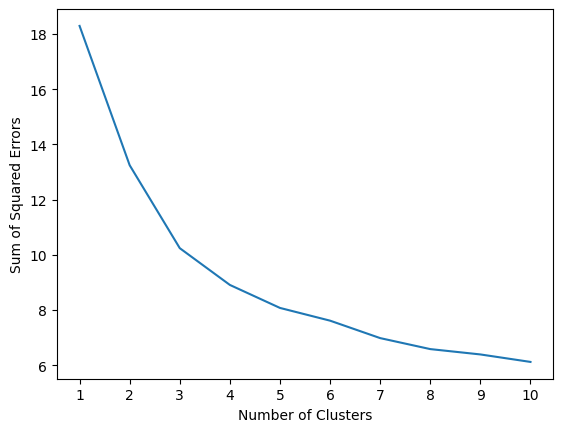

In [10]:
# k calculation method
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_sigmoid)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)

plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")

plt.show()



In [11]:
# From the resulting graph, you must select the strongest inflection. We do this with the help of the kneed library

from kneed import KneeLocator

kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

print('Optimal number of clusters:', kl.elbow)

Optimal number of clusters: 3


c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


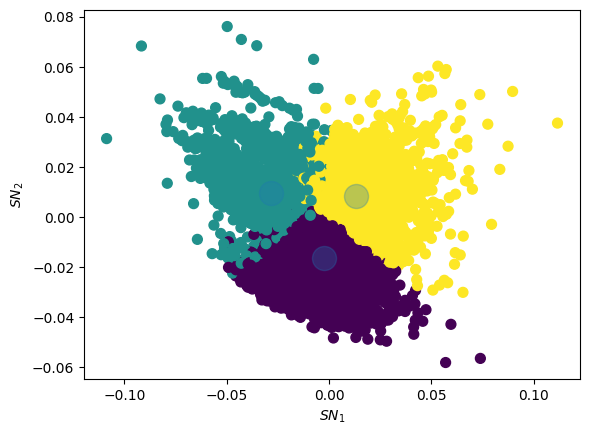

In [12]:
# the number of clusters to form as well as the number of centroids to generate
n_clusters = kl.elbow

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_sigmoid)

y = kmeans.predict(X_sigmoid)
plt.scatter(X_sigmoid[:, 0], X_sigmoid[:, 1], c=y, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, alpha=0.3);
plt.xlabel(r'$SN_1$')
plt.ylabel(r'$SN_2$')

plt.show()

Bad clustering, let's try another method for choosing the number of clusters - Silhouette Method

c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of

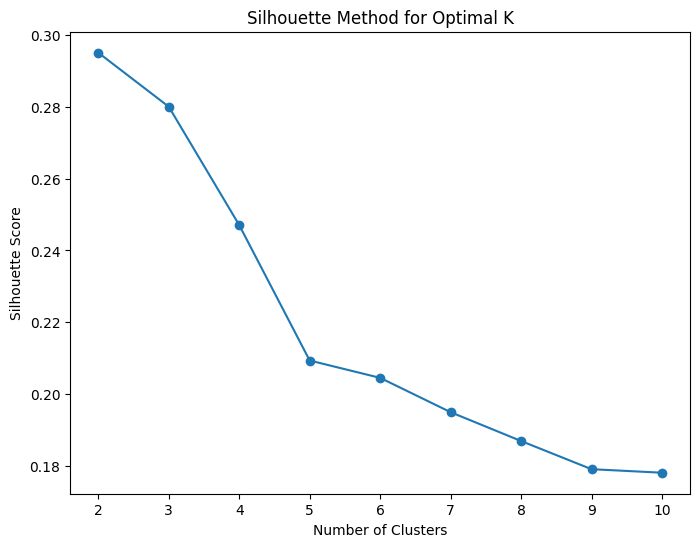

In [13]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Define the range of clusters to test
k_range = range(2, 11)  # Start from 2 clusters

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sigmoid)
    
    silhouette_avg = silhouette_score(X_sigmoid, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.show()


The best number of clusters = 2

## Gaussian Mixture Model algorithm

The Gaussian mixture model uses multiple Gaussian distributions to fit arbitrarily shaped data.

The advantage of this method is that the borders of each cluster compose ellipsoids of different measures. However, this method can only be used with a predetermined number of clusters.

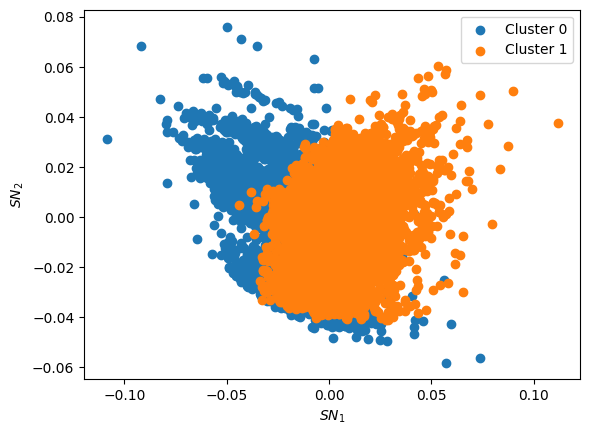

In [14]:
from sklearn.mixture import GaussianMixture

# define the model
gaussian_model = GaussianMixture(n_components=2)

# train the model
gaussian_model.fit(X_sigmoid)

# assign each data point to a cluster
y = gaussian_model.predict(X_sigmoid)

# get all of the unique clusters
gaussian_clusters = np.unique(y)


for gaussian_cluster in gaussian_clusters:
    # get data points that fall in this cluster
    index = np.where(y == gaussian_cluster)[0]
    # make the plot
    plt.scatter(X_sigmoid[index, 0], X_sigmoid[index, 1], label=f'Cluster {gaussian_cluster}')

plt.xlabel(r'$SN_1$')
plt.ylabel(r'$SN_2$')
plt.legend()
# show the Gaussian Mixture plot
plt.show()



On this dataset both clustering methods work poorly

In my opinion, the reason for poor clustering is in the inappropriate data preprocessing. Perhaps the wrong features were selected at the stage of feature selection